In [5]:

import os
import warnings
import matplotlib as plt
from xgboost import XGBRegressor , plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  # For regression tasks
from sklearn.tree import DecisionTreeClassifier  # For classification tasks
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score



In [7]:
import hopsworks

with open('hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [8]:
project = hopsworks.login(project="ScalableMLandDeepLcourse")
fs = project.get_feature_store()

2024-12-18 19:43:35,919 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-18 19:43:35,936 INFO: Initializing external client
2024-12-18 19:43:35,938 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-18 19:43:43,065 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170582


## 3.Write a training pipeline

### 3.1 Get datas from features groups

In [19]:
# Load the Feature Groups for air quality and weather data
traffic_fg = fs.get_feature_group(name="stockholm_traffic", version=1)
weather_fg = fs.get_feature_group(name="stockholm_weather_holiday", version=1)

# Read the data from both feature groups
traffic_df = traffic_fg.read()
weather_df = weather_fg.read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.09s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.57s) 


In [20]:
traffic_df

,frc,currentspeed,freeflowspeed,currenttraveltime,freeflowtraveltime,confidence,roadclosure,coordinates,relativespeed,date
0,FRC7,18,18,151,151,1.0,False,LINESTRING (18.068969212022807 59.344333147360...,1.000000,2024-12-18 19:00:00+00:00
1,FRC4,17,32,57,30,1.0,False,LINESTRING (18.049210719310025 59.350060976202...,0.531250,2024-12-18 19:00:00+00:00
2,FRC3,17,25,55,37,1.0,False,LINESTRING (18.063042871203066 59.345046598587...,0.680000,2024-12-18 19:00:00+00:00
3,FRC4,8,11,20,15,1.0,False,LINESTRING (18.04846774741273 59.3502286491923...,0.727273,2024-12-18 19:00:00+00:00
4,FRC3,27,27,10,10,1.0,False,LINESTRING (18.042271844586878 59.350079777496...,1.000000,2024-12-18 19:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
327,FRC7,19,19,75,75,1.0,False,LINESTRING (18.0545509974599 59.34064910896488...,1.000000,2024-12-18 20:00:00+00:00
328,FRC4,11,17,41,26,1.0,False,LINESTRING (18.055653385365304 59.334811280087...,0.647059,2024-12-18 20:00:00+00:00
329,FRC1,34,50,128,87,1.0,False,LINESTRING (18.056195191586426 59.361159961379...,0.680000,2024-12-18 20:00:00+00:00
330,FRC4,27,27,27,27,1.0,False,LINESTRING (18.05162873073749 59.3480613991587...,1.000000,2024-12-18 20:00:00+00:00


In [21]:
traffic_df["relativespeed_h1"] = (
    traffic_df.sort_values("date").groupby("coordinates")["relativespeed"].shift(-1)  # Décalage pour +1H dans chaque segment
)


In [35]:
traffic_df

,frc,currentspeed,freeflowspeed,currenttraveltime,freeflowtraveltime,confidence,roadclosure,coordinates,relativespeed,date,relativespeed_h1
0,FRC7,18,18,151,151,1.0,False,LINESTRING (18.068969212022807 59.344333147360...,1.000000,2024-12-18 19:00:00+00:00,0.823529
1,FRC4,17,32,57,30,1.0,False,LINESTRING (18.049210719310025 59.350060976202...,0.531250,2024-12-18 19:00:00+00:00,0.696970
2,FRC3,17,25,55,37,1.0,False,LINESTRING (18.063042871203066 59.345046598587...,0.680000,2024-12-18 19:00:00+00:00,0.640000
3,FRC4,8,11,20,15,1.0,False,LINESTRING (18.04846774741273 59.3502286491923...,0.727273,2024-12-18 19:00:00+00:00,1.000000
4,FRC3,27,27,10,10,1.0,False,LINESTRING (18.042271844586878 59.350079777496...,1.000000,2024-12-18 19:00:00+00:00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
327,FRC7,19,19,75,75,1.0,False,LINESTRING (18.0545509974599 59.34064910896488...,1.000000,2024-12-18 20:00:00+00:00,NaN
328,FRC4,11,17,41,26,1.0,False,LINESTRING (18.055653385365304 59.334811280087...,0.647059,2024-12-18 20:00:00+00:00,NaN
329,FRC1,34,50,128,87,1.0,False,LINESTRING (18.056195191586426 59.361159961379...,0.680000,2024-12-18 20:00:00+00:00,NaN
330,FRC4,27,27,27,27,1.0,False,LINESTRING (18.05162873073749 59.3480613991587...,1.000000,2024-12-18 20:00:00+00:00,NaN


In [40]:
traffic_df.to_csv('traffic_data.csv', index=False)

### 3.2 Create a query

In [ ]:
selected_features = traffic_fg.select_all(), on = ['date'].join(weather_fg.select_all(), on = ['date'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,pm25,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2022-09-02 00:00:00+00:00,7,13.871500,6.2215,0.8,14.440443,353.648407
1,2022-09-04 00:00:00+00:00,7,15.621500,5.5215,0.2,9.720000,44.154472
2,2022-09-13 00:00:00+00:00,12,14.621500,10.1715,12.2,26.758923,171.560440
3,2022-09-24 00:00:00+00:00,23,15.421500,9.1715,0.8,8.049845,171.922943
4,2022-10-20 00:00:00+00:00,11,8.471499,0.8715,0.0,11.013882,261.155853
5,2022-10-24 00:00:00+00:00,11,9.971499,6.1215,6.7,19.671949,108.611481
6,2022-11-29 00:00:00+00:00,20,3.071500,2.0215,2.8,12.599998,109.961502
7,2022-12-09 00:00:00+00:00,32,-3.278500,-6.9785,1.4,8.089993,338.929138
8,2023-01-03 00:00:00+00:00,9,-0.078500,-6.1785,0.3,17.317459,301.269714
9,2023-01-13 00:00:00+00:00,13,4.771500,2.1215,2.1,15.876775,188.502518


### 3.3 Create a feature view for training with the query

In [ ]:
feature_view = fs.get_or_create_feature_view(
    name = "trafic_fv",
    description = "traffic, weather and holidays joined to predict traffic next hour",
    version = 1,
    labels = ['relativespeed_h1'],
    query = selected_features
)

### 3.4 Split datas

In [7]:
# order data by dates to find good date to split
dates_ordered = selected_features.read().sort_values(by = 'date').date.reindex()

# define train/test split
train_per = 0.7
train_split = int(dates_ordered.shape[0]*train_per)

# find correct date to split
start_test_date = dates_ordered.iloc[train_split+1]
start_test_date

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


Timestamp('2023-11-11 00:00:00+0000', tz='UTC')

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=start_test_date
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


In [9]:
train_features = X_train.drop(['date'], axis=1)
test_features = X_test.drop(['date'], axis=1)

### 3.5 Train the model with the training split


In [ ]:
# XGBOOST / RANDOM Forest at first (maybe use Random Search for hyperparameters tunning )

In [10]:
# Creating an instance of the XGBoost Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Fitting the XGBoost Regressor to the training data
tree_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 3.6 Infere on the test split and evaluate

In [11]:
# Predicting target values on the test set
y_pred_train = tree_regressor.predict(train_features)
y_pred_test = tree_regressor.predict(test_features)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")

MSE: 106.93736247188653
R squared: 0.09280508756637573


In [12]:
df = y_test
df['predicted_pm25'] = y_pred_test

In [13]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df = df.iloc[-50:]
df.tail()

,pm25,predicted_pm25,date
511,24,16.783035,2024-04-25 00:00:00+00:00
69,14,14.899062,2024-04-26 00:00:00+00:00
537,27,20.330097,2024-04-27 00:00:00+00:00
178,33,35.914852,2024-04-28 00:00:00+00:00
70,49,26.271387,2024-04-29 00:00:00+00:00


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "traffic_pred_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

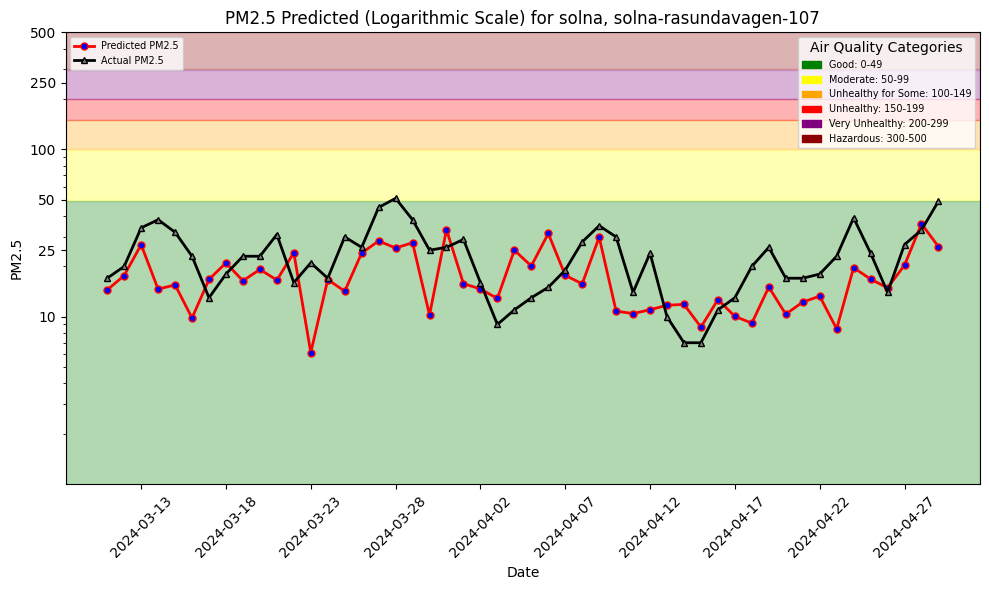

In [ ]:
file_path = images_dir + "/relative_speed_forecast_vs_reality_with_tree.png"

## Show plot the diff

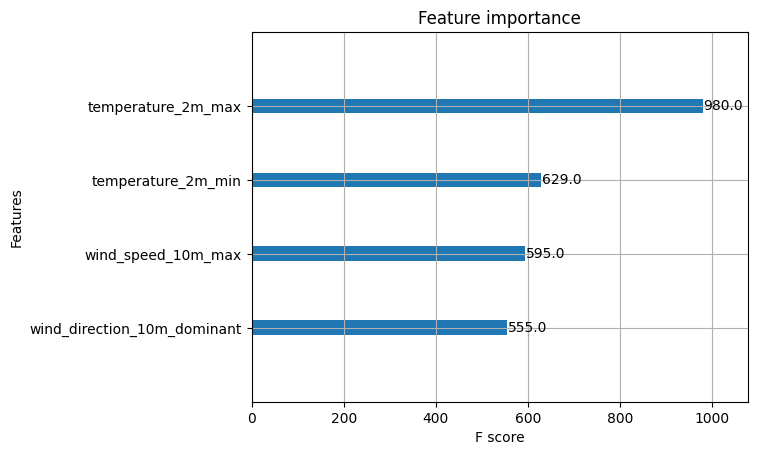

In [16]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(tree_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

### 3.7 Save the model

In [17]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [18]:
# Saving the XGBoost regressor object as a json file in the model directory
tree_regressor.save_model(model_dir + "/model.json")

In [19]:
res_dict = { 
        "MSE_train": str(train_mse),
        "MSE_test": str(test_mse),
    }

In [ ]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named ''

traffic_model = mr.python.create_model(
    name="trafic_pred_tree", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Traffic Patterns predictor with regression tree",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
traffic_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/367626 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/60034 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/18978 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/38104 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/88047 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/130 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/657 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1170583/models/air_quality_xgboost_model/7


Model(name: 'air_quality_xgboost_model', version: 7)